In [2]:
%load_ext lab_black
%matplotlib inline

In [3]:
# %%cmd

# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip kaleido

# pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pip orca

# 0. Data and Packages

#### References
- [How to Select a Model For Your Time Series Prediction Task](https://neptune.ai/blog/select-model-for-time-series-prediction-task)  
- [Visualizing Data with Pairs Plots in Python](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


print(plotly.__version__)
print(kaleido.__version__)

from datetime import date

5.6.0
0.1.0.post1


In [5]:
## Load original dataframe

today = str(date.today()).replace("-", "")

original_df = pd.read_csv(f"analyze-dataset/merged_data_{today}.csv")
df = original_df.copy()

###### drop some useless columns
df = df.drop(
    columns=[
        "domestic_debt",  # remove, use total natinal debt
        "external_debt",  # remove, use total natinal debt
        "Compound SORA - 1 month",  # remove since lack of data
        "Compound SORA - 3 month",  # remove since lack of data
        "Compound SORA - 6 month",  # remove since lack of data
        "average_MNE_per_employee_overall_economy",  # remove since lack of data
        "Resident Unemployment Rate",  # remove, use total unemployment rate
        "Citizen Unemployment Rate",  # remove, use total unemployment rate
        "GDP_year_on_year_growth_rate_current_price",  # remove, use in-chain data
        "household_net_worth",  # remove, consider as irrelevant
        "gross_fixed_capital_formation_current_price",  # remove, use in chain
    ]
)

df = df.rename(
    columns={
        "lag3q_Age Dependency Ratio: Residents Aged Under 15 Years And 65 Years Per Hundred Residents Aged 15-64 Years (Number)": "lag3q_Age Dependency Ratio (15-64 Years)"
    }
)

# add quarter information
# TODO: one hot encoding for Quarter
df["Year"] = df["Data Series"].apply(lambda s: int(s.split(" ")[0]))
df["Qrt"] = df["Data Series"].apply(lambda s: int(s.split(" ")[1][0]))
display(df.head())

for c in df.columns:
    print(c)
print(df.shape)

Data Series  total_deposits_from_non-bank_customer  Prime Lending Rate  \
0     1991 1Q                               194776.5            7.436667   
1     1991 2Q                               198990.8            7.523333   
2     1991 3Q                               206741.1            7.890000   
3     1991 4Q                               211731.7            7.483333   
4     1992 1Q                               218934.1            6.303333   

   CPI_all_items_base_2019  DSPI_all_items_base_2018  IPI_all_items_base_2018  \
0                64.281333                107.336667               118.772667   
1                64.772667                102.607667               115.454667   
2                65.124000                101.448333               114.300333   
3                65.425333                101.229667               113.867667   
4                65.710000                 97.909000               110.981333   

   EPI_all_items_base_2018  lag3q_Total Population (Number)  \
0               179.648333                        3047132.0   
1               170.185667                        3047132.0   
2               167.685667                        3047132.0   
3               165.380667                        3135083.0   
4               159.644000                        3135083.0   

   lag3q_Total Population Growth (Per Cent)  \
0                                       2.3   
1                                       2.3   
2                                       2.3   
3                                       2.9   
4                                       2.9   

   lag3q_Age Dependency Ratio (15-64 Years)  ...  \
0                                      40.8  ...   
1                                      40.8  ...   
2                                      40.8  ...   
3                                      41.0  ...   
4                                      41.0  ...   

   housing_and_development_board_resale_price_index  \
0                                              24.9   
1                                              25.5   
2                                              25.2   
3                                              25.1   
4                                              25.8   

   GDP_year_on_year_growth_rate_in_chain_2015  GDP_in_chain_2015  \
0                                         6.4            25457.6   
1                                         6.5            25819.2   
2                                         7.3            26244.2   
3                                         6.5            26456.1   
4                                         5.7            26919.1   

   Personal Disposable Income (Million Dollars)  \
0                                       10497.8   
1                                       10067.8   
2                                       10521.4   
3                                       12412.4   
4                                       11200.1   

   Personal Saving (Million Dollars)  Personal Saving Rate (Per Cent)  \
0                             2179.8                             20.8   
1                             1852.3                             18.4   
2                             2040.7                             19.4   
3                             3463.3                             27.9   
4                             2228.7                             19.9   

   Total Unemployment Rate  Unit Labour Cost Of Overall Economy  Year  Qrt  
0                      NaN                                 79.0  1991    1  
1                      NaN                                 80.9  1991    2  
2                      NaN                                 81.6  1991    3  
3                      NaN                                 82.6  1991    4  
4                      1.5                                 83.5  1992    1  

[5 rows x 25 columns]

Data Series
total_deposits_from_non-bank_customer
Prime Lending Rate
CPI_all_items_base_2019
DSPI_all_items_base_2018
IPI_all_items_base_2018
EPI_all_items_base_2018
lag3q_Total Population (Number)
lag3q_Total Population Growth (Per Cent)
lag3q_Age Dependency Ratio (15-64 Years)
lag3q_per_capita_GDP_in_chain_2015
total_change_in_employment_quarterly
composite_leading_index_base_2015
total_government_debt
gross_fixed_capital_formation_in_chain_2015
housing_and_development_board_resale_price_index
GDP_year_on_year_growth_rate_in_chain_2015
GDP_in_chain_2015
Personal Disposable Income (Million Dollars)
Personal Saving (Million Dollars)
Personal Saving Rate (Per Cent)
Total Unemployment Rate
Unit Labour Cost Of Overall Economy
Year
Qrt
(122, 25)


In [6]:
# print all columns

for col in list(df.columns):
    print(col)

Data Series
total_deposits_from_non-bank_customer
Prime Lending Rate
CPI_all_items_base_2019
DSPI_all_items_base_2018
IPI_all_items_base_2018
EPI_all_items_base_2018
lag3q_Total Population (Number)
lag3q_Total Population Growth (Per Cent)
lag3q_Age Dependency Ratio (15-64 Years)
lag3q_per_capita_GDP_in_chain_2015
total_change_in_employment_quarterly
composite_leading_index_base_2015
total_government_debt
gross_fixed_capital_formation_in_chain_2015
housing_and_development_board_resale_price_index
GDP_year_on_year_growth_rate_in_chain_2015
GDP_in_chain_2015
Personal Disposable Income (Million Dollars)
Personal Saving (Million Dollars)
Personal Saving Rate (Per Cent)
Total Unemployment Rate
Unit Labour Cost Of Overall Economy
Year
Qrt


# 1. First Glance

In [7]:
def plot_univariate_scatter(df, x_name, y_name, figsize=None):
    plt.figure(figsize=figsize)
    plt.scatter(x_name, y_name, data=df, marker="x")
    plt.title(f"{y_name} vs. {x_name}")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()


def plot_univariate_line(df, x_name, y_name):
    fig = px.line(x=df[x_name], y=df[y_name], title=f"{y_name} vs. {x_name}")
    fig.show()

## 1.1 univariate distribution (Boxplot)   

- [Plot subplots different size](https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots)

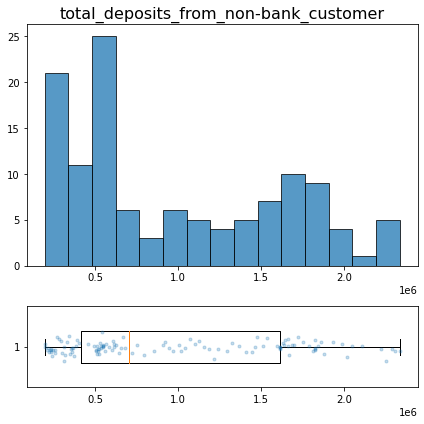

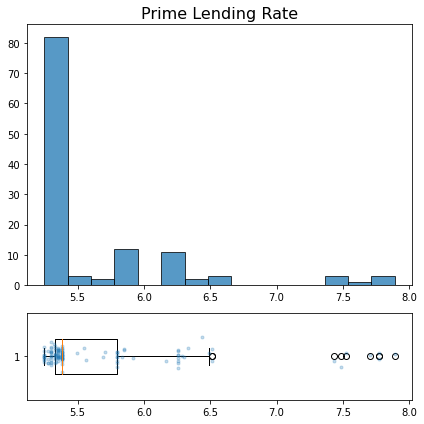

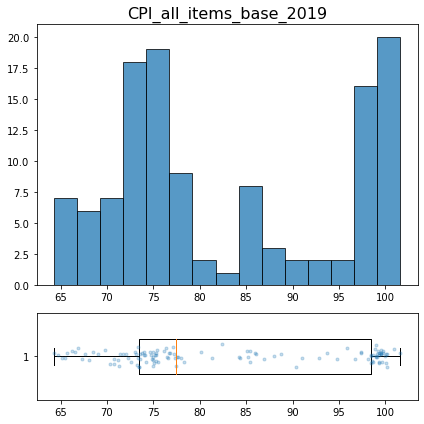

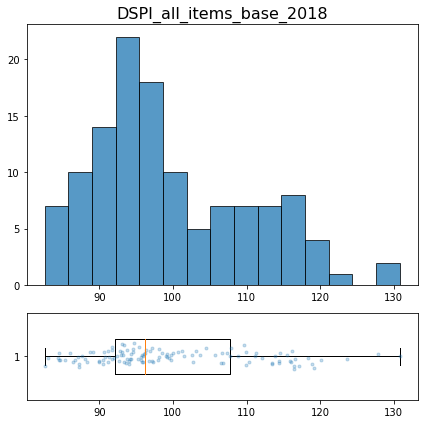

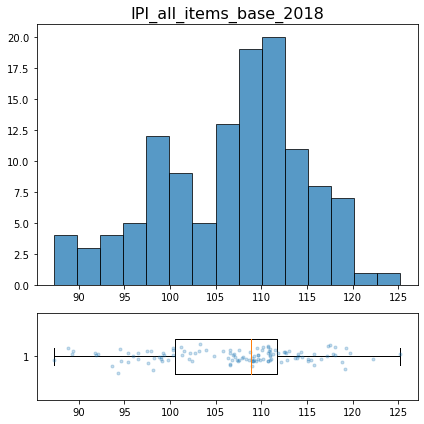

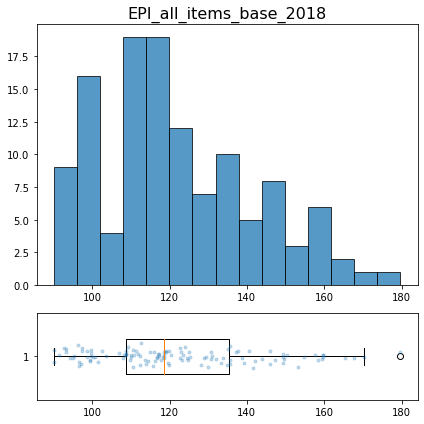

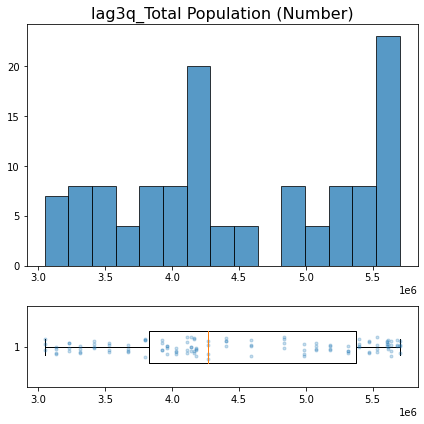

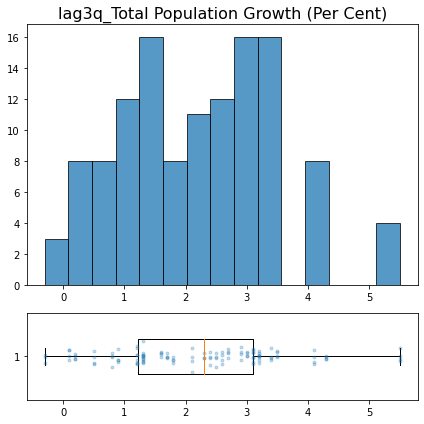

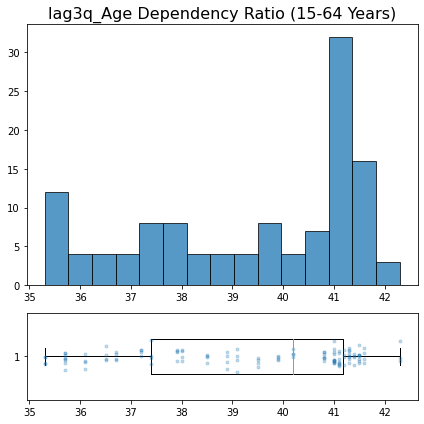

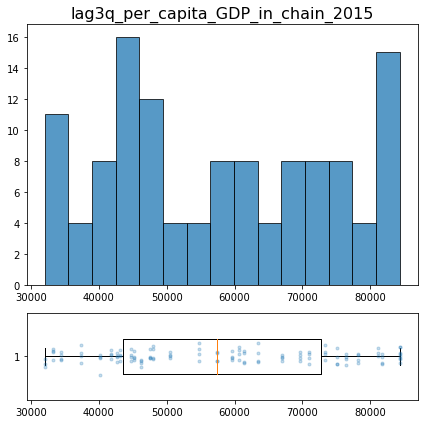

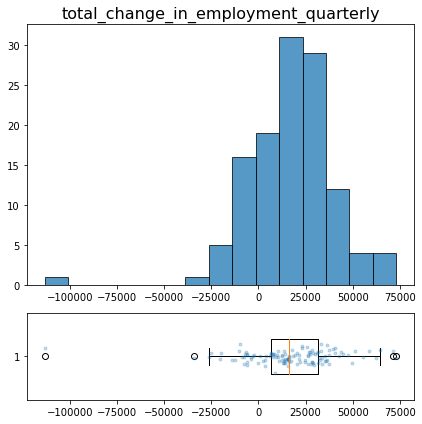

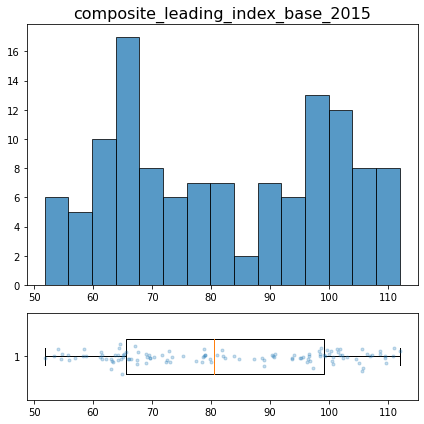

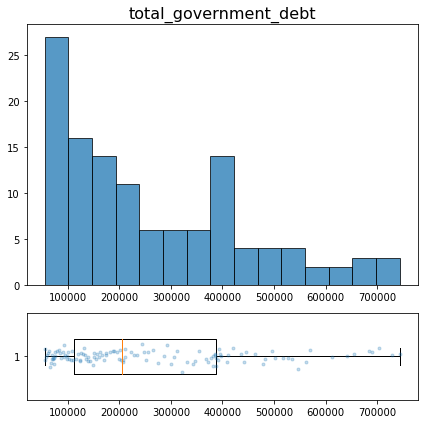

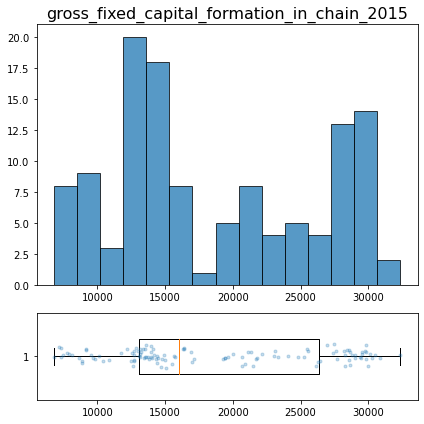

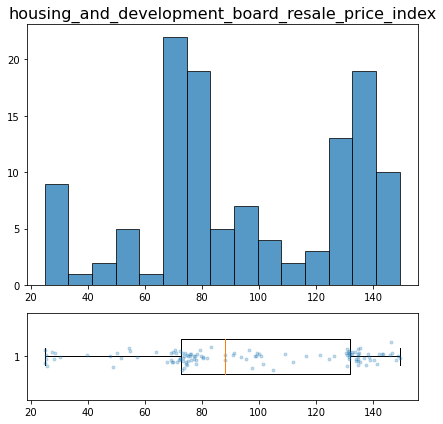

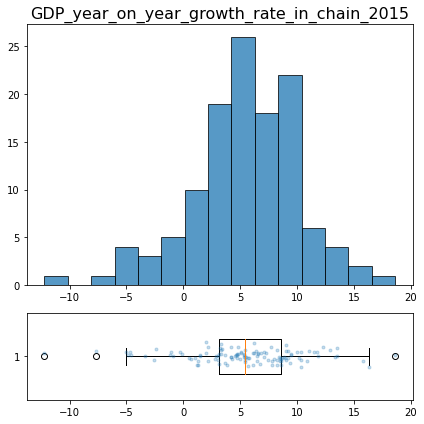

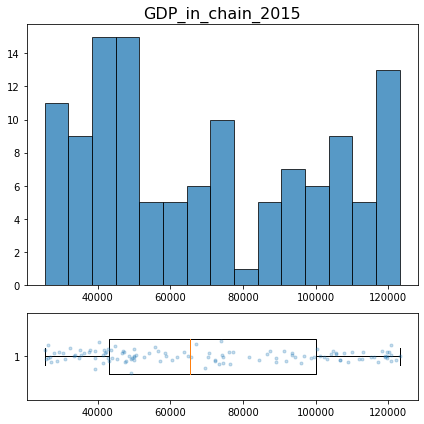

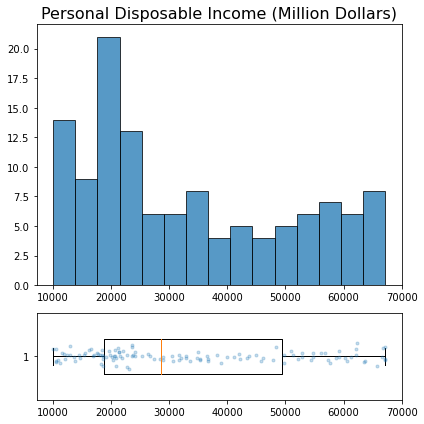

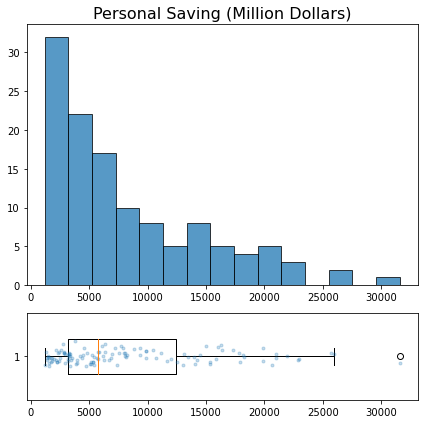

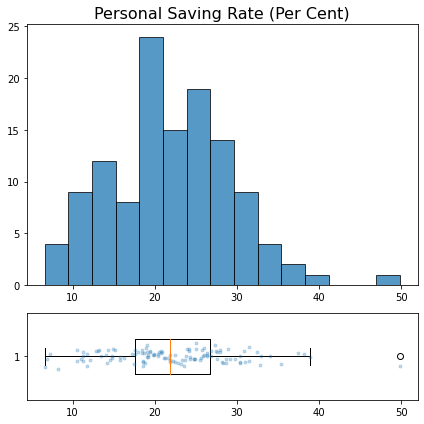

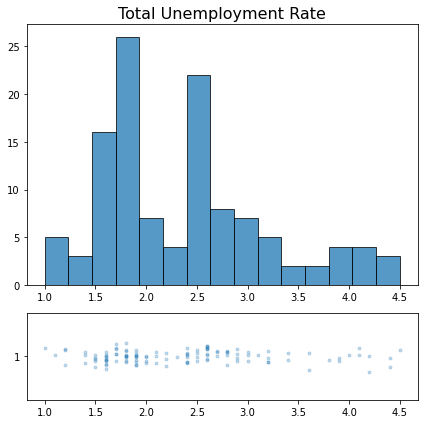

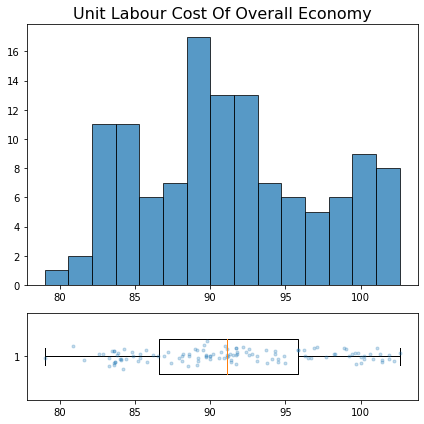

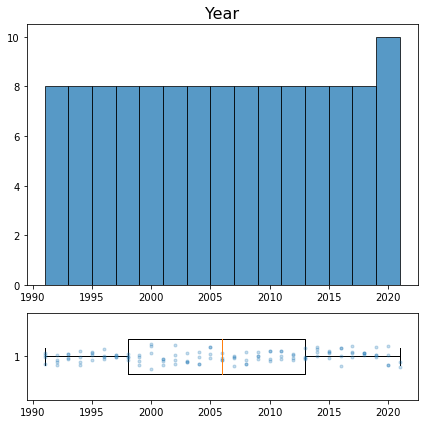

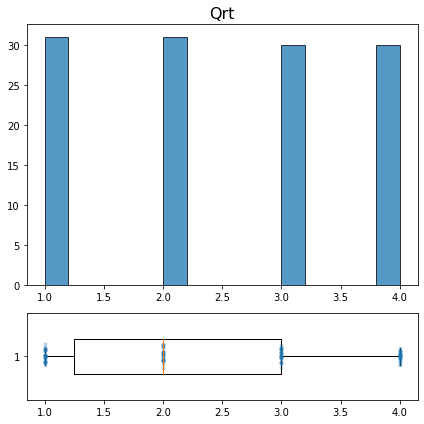

In [59]:
# plt.figure(figsize=(24, 8))
# plt.boxplot(df.iloc[:, 1:])
# plt.show()

for x_col in df.columns[1:]:

    fig, (ax1, ax2) = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(6, 6)
    )

    ## histogram
    # ax1.grid(True)
    ax1.set_title(x_col, fontsize=16)
    ax1.hist(df[x_col], edgecolor="black", bins=15, alpha=0.75)

    ax2.boxplot(df[x_col], vert=False, widths=0.4)

    x = np.random.normal(1, 0.06, size=len(df[x_col]))
    ax2.plot(df[x_col], x, ".", alpha=0.25)

    plt.tight_layout()
    plt.show()

## 1.2 line plot

['total_deposits_from_non-bank_customer', 'Prime Lending Rate', 'CPI_all_items_base_2019', 'DSPI_all_items_base_2018', 'IPI_all_items_base_2018', 'EPI_all_items_base_2018', 'lag3q_Total Population (Number)', 'lag3q_Total Population Growth (Per Cent)', 'lag3q_Age Dependency Ratio (15-64 Years)', 'lag3q_per_capita_GDP_in_chain_2015', 'total_change_in_employment_quarterly', 'composite_leading_index_base_2015', 'total_government_debt', 'gross_fixed_capital_formation_in_chain_2015', 'housing_and_development_board_resale_price_index', 'GDP_year_on_year_growth_rate_in_chain_2015', 'GDP_in_chain_2015', 'Personal Disposable Income (Million Dollars)', 'Personal Saving (Million Dollars)', 'Personal Saving Rate (Per Cent)', 'Total Unemployment Rate', 'Unit Labour Cost Of Overall Economy', 'Year', 'Qrt']


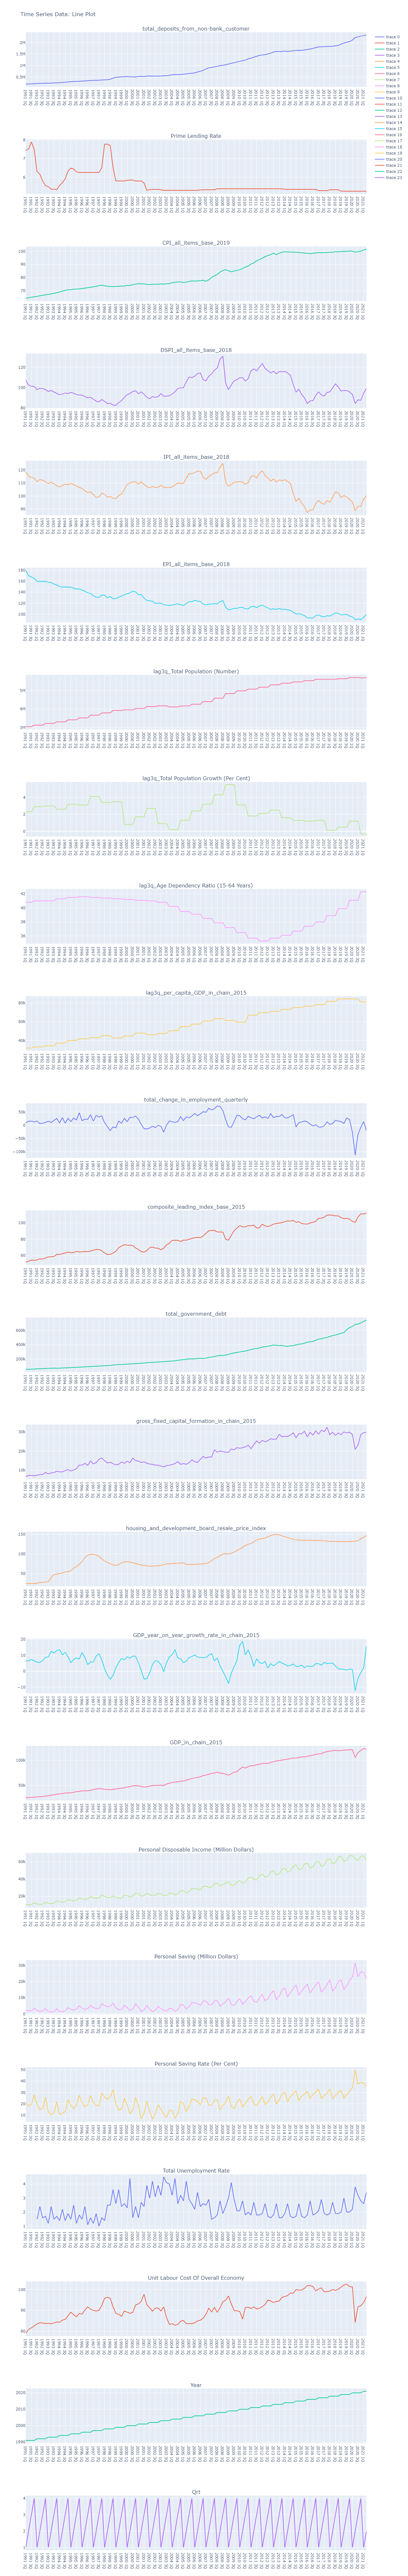

In [91]:
## line plot

time_col_name = "Data Series"

x_cols = list(df.columns)[1:]
print(x_cols)
fig = make_subplots(rows=len(x_cols), cols=1, subplot_titles=x_cols)

for i, col_name in enumerate(x_cols):
    fig.add_trace(go.Scatter(x=df["Data Series"], y=df[col_name]), row=i + 1, col=1)

fig.update_layout(height=8000, width=800, title_text="Time Series Data: Line Plot")


fig.write_image("./analyze-dataset/line_plot.png")
fig.show()

# 2. Univariate Analysis

## 2.1 Pearson Correlation Coefficient  

Correlation in python:  
- The Pearson correlation is implemented in multiple packages including Numpy, Scipy, and Pandas. 
- If you have null or missing values in your data, correlation function in Pandas will drop those rows before computing whereas you need to manually remove those data if using Numpy or Scipy’s implementations.

In [92]:
def get_pearson_corr(df, col_1, col_2):
    res = stats.pearsonr(df[col_1], df[col_2])
    return res


def plot_corr_heatmap(df, method="pearson"):
    """
    Credit: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
    
    """
    # Compute the correlation matrix
    corr = df.corr(method=method)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        annot_kws={"fontsize": 7},
    )

    plt.savefig("./analyze-dataset/heatmap.png")

    return corr

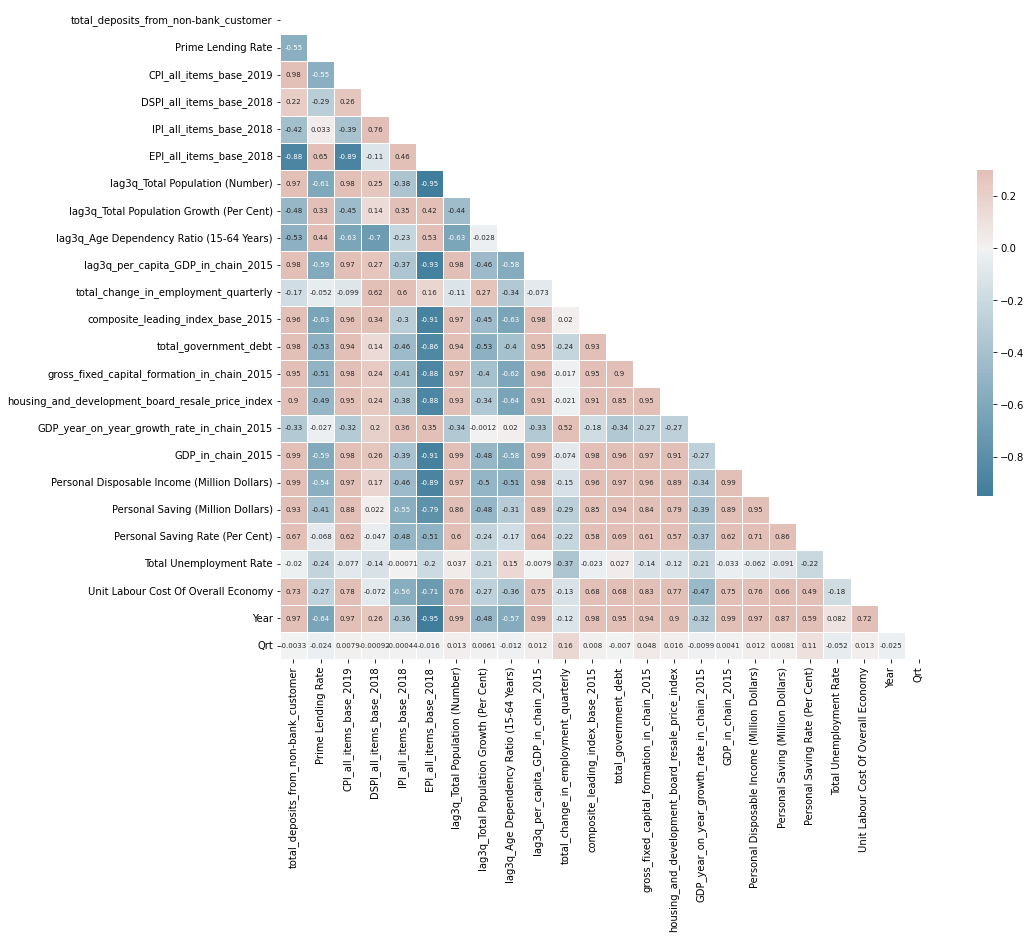

In [93]:
temp_df = df.iloc[:, 1:]

# print(temp_df.dtypes)
# display(temp_df)

temp_df = temp_df.astype("float64")

corr = plot_corr_heatmap(temp_df)

corr.to_csv("./analyze-dataset/corr_heatmap_all_variables.csv")

## 2.2 Dependent variable

- credit: https://realpython.com/numpy-scipy-pandas-correlation-python/#example-pandas-correlation-calculation  


In [94]:
def plot_acf_pacf(df, col_name):
    pass

In [95]:
# y_df = df[["Data Series", Y_COL_NAME]].copy()


# y_df[Y_COL_NAME + "_diff_1"] = y_df[Y_COL_NAME].diff(1)

# y_df = y_df.iloc[1:]

# # display(y_df.head())

# plot_univariate_line(df, "Data Series", Y_COL_NAME)

# plot_univariate_line(y_df, "Data Series", Y_COL_NAME + "_diff_1")

Data Series  total_deposits_from_non-bank_customer  Prime Lending Rate  \
0     1991 1Q                               194776.5            7.436667   
1     1991 2Q                               198990.8            7.523333   
2     1991 3Q                               206741.1            7.890000   
3     1991 4Q                               211731.7            7.483333   
4     1992 1Q                               218934.1            6.303333   

   CPI_all_items_base_2019  DSPI_all_items_base_2018  IPI_all_items_base_2018  \
0                64.281333                107.336667               118.772667   
1                64.772667                102.607667               115.454667   
2                65.124000                101.448333               114.300333   
3                65.425333                101.229667               113.867667   
4                65.710000                 97.909000               110.981333   

   EPI_all_items_base_2018  lag3q_Total Population (Number)  \
0               179.648333                        3047132.0   
1               170.185667                        3047132.0   
2               167.685667                        3047132.0   
3               165.380667                        3135083.0   
4               159.644000                        3135083.0   

   lag3q_Total Population Growth (Per Cent)  \
0                                       2.3   
1                                       2.3   
2                                       2.3   
3                                       2.9   
4                                       2.9   

   lag3q_Age Dependency Ratio (15-64 Years)  ...  \
0                                      40.8  ...   
1                                      40.8  ...   
2                                      40.8  ...   
3                                      41.0  ...   
4                                      41.0  ...   

   housing_and_development_board_resale_price_index  \
0                                              24.9   
1                                              25.5   
2                                              25.2   
3                                              25.1   
4                                              25.8   

   GDP_year_on_year_growth_rate_in_chain_2015  GDP_in_chain_2015  \
0                                         6.4            25457.6   
1                                         6.5            25819.2   
2                                         7.3            26244.2   
3                                         6.5            26456.1   
4                                         5.7            26919.1   

   Personal Disposable Income (Million Dollars)  \
0                                       10497.8   
1                                       10067.8   
2                                       10521.4   
3                                       12412.4   
4                                       11200.1   

   Personal Saving (Million Dollars)  Personal Saving Rate (Per Cent)  \
0                             2179.8                             20.8   
1                             1852.3                             18.4   
2                             2040.7                             19.4   
3                             3463.3                             27.9   
4                             2228.7                             19.9   

   Total Unemployment Rate  Unit Labour Cost Of Overall Economy  Year  Qrt  
0                      NaN                                 79.0  1991    1  
1                      NaN                                 80.9  1991    2  
2                      NaN                                 81.6  1991    3  
3                      NaN                                 82.6  1991    4  
4                      1.5                                 83.5  1992    1  

[5 rows x 25 columns]

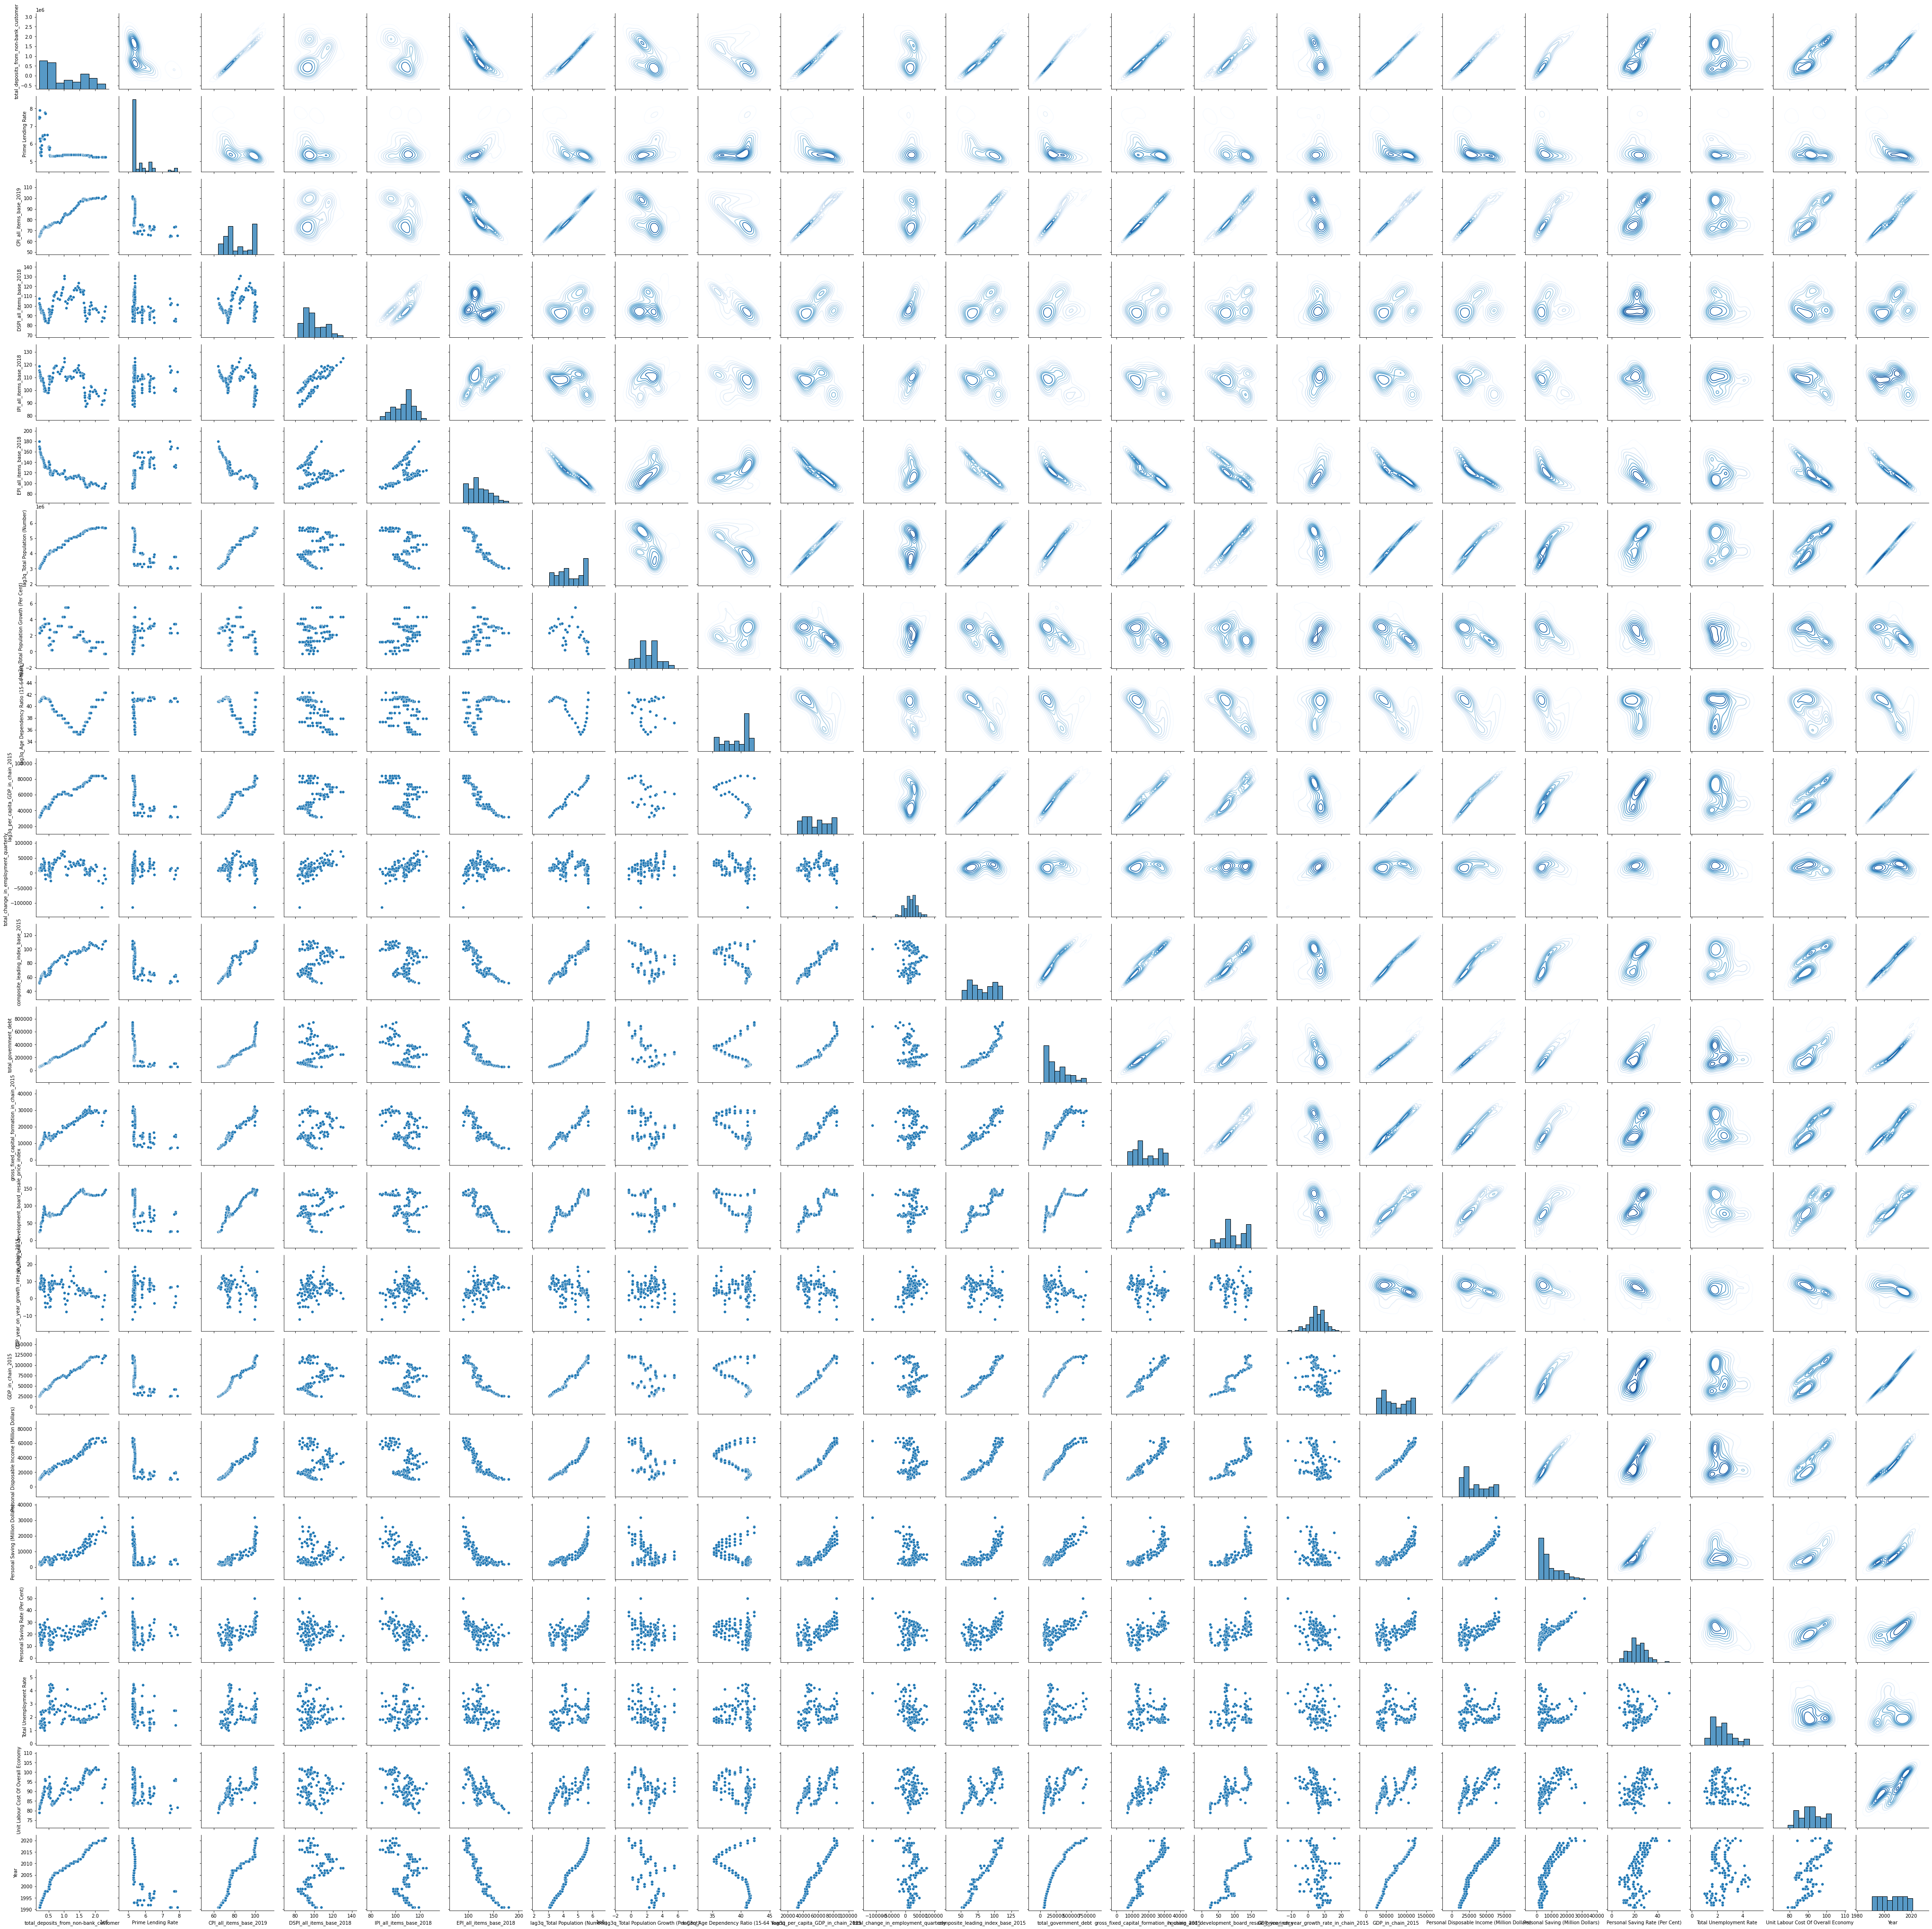

In [96]:
import seaborn as sns

temp_df = df.copy()
temp_df["Qrt"] = temp_df["Data Series"].apply(lambda s: s.split(" ")[1][0])

display(temp_df.head())

g = sns.PairGrid(temp_df)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, cmap="Blues")
# g.add_legend()

In [97]:
g.savefig("./analyze-dataset/grid_pair.png")

In [98]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(SLR_df.iloc[:, :2])
# result.plot()

 - feature selection, consider F-regression: https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2

### 2.2.2 AR models  

- credit: https://pythondata.com/forecasting-time-series-autoregression/  


In [99]:
# total deposit

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8, 10))

# plt.suptitle(Y_COL_NAME, fontsize=16)

# plot_acf(y_df[Y_COL_NAME], ax=ax1, lags=30, use_vlines=True)

# plot_pacf(y_df[Y_COL_NAME], ax=ax2, lags=30, method="ywm", use_vlines=True)
# plt.show()

In [100]:
# first difference of total deposits

# Y_DIFF_1 = Y_COL_NAME + "_diff_1"

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8, 10))

# plt.suptitle(Y_DIFF_1, fontsize=16)

# plot_acf(y_df[Y_DIFF_1], ax=ax1, lags=30, use_vlines=True)

# plot_pacf(y_df[Y_DIFF_1], ax=ax2, lags=30, method="ywm", use_vlines=True)
# plt.show()

In [101]:
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import r2_score

In [102]:
# X = y_df[Y_DIFF_1].copy()

# X_N = X.shape[0]

# # print(X)
# # print(X_N)

# train_data = X.iloc[1 : X_N - 12]
# test_data = X.iloc[X_N - 12 :]

# # print(train_data)
# # print(test_data)

# # train the autoregression model
# model = AutoReg(train_data, lags=50)
# model_fitted = model.fit()

# # make predictions
# predictions = model_fitted.predict(
#     start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False
# )

# print(model_fitted.aic, model_fitted.hqic, model_fitted.bic)


# # create a comparison dataframe
# compare_df = pd.concat([y_df[Y_DIFF_1].tail(12), predictions], axis=1).rename(
#     columns={"stationary": "actual", 0: "predicted"}
# )

# # plot the two values
# compare_df.plot()

# print(y_df[Y_DIFF_1].tail(12))
# print(predictions)

# r2 = r2_score(y_df[Y_DIFF_1].tail(12), predictions)


# print(r2)

### 2.2.3 MA models